# Netflow data
The data was taken from: [Machine Learning-Based NIDS Datasets](https://staff.itee.uq.edu.au/marius/NIDS_datasets/)

**Note: you will need to unzip the file cyberdata_mlai/data/netflow/7ca78ae35fa4961a_MOHANAD_A4706.zip** before you run this notebook.

In [1]:
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ipaddress

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from matplotlib import pyplot
from summarytools import dfSummary
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Read data

In [2]:
data = pd.read_csv("./data/netflow/7ca78ae35fa4961a_MOHANAD_A4706/data/NF-ToN-IoT.csv")

In [3]:
data.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,192.168.1.195,63318,52.139.250.253,443,6,91.00,181,165,2,1,24,327,0,Benign
1,192.168.1.79,57442,192.168.1.255,15600,17,0.00,63,0,1,0,0,0,0,Benign
2,192.168.1.79,57452,239.255.255.250,15600,17,0.00,63,0,1,0,0,0,0,Benign
3,192.168.1.193,138,192.168.1.255,138,17,10.16,472,0,2,0,0,0,0,Benign
4,192.168.1.79,51989,192.168.1.255,15600,17,0.00,63,0,1,0,0,0,0,Benign


In [4]:
data.dtypes

IPV4_SRC_ADDR                  object
L4_SRC_PORT                     int64
IPV4_DST_ADDR                  object
L4_DST_PORT                     int64
PROTOCOL                        int64
L7_PROTO                      float64
IN_BYTES                        int64
OUT_BYTES                       int64
IN_PKTS                         int64
OUT_PKTS                        int64
TCP_FLAGS                       int64
FLOW_DURATION_MILLISECONDS      int64
Label                           int64
Attack                         object
dtype: object

# Generate numerical features

In [5]:
def convert_ip(ip):
    try:
        ip_num = int(ipaddress.ip_address(ip))
        is_private = ipaddress.ip_address(ip).is_private
        return ip_num, is_private
    except ValueError:
        return None, None

In [6]:
data["IPV4_SRC_ADDR_NUMERIC"], data["IPV4_SRC_ADDR_PRIVATE"] = zip(
    *data["IPV4_SRC_ADDR"].apply(convert_ip)
)
data["IPV4_DST_ADDR_NUMERIC"], data["IPV4_DST_ADDR_PRIVATE"] = zip(
    *data["IPV4_DST_ADDR"].apply(convert_ip)
)

In [7]:
data.pop("IPV4_SRC_ADDR")
data.pop("IPV4_DST_ADDR")

0           52.139.250.253
1            192.168.1.255
2          239.255.255.250
3            192.168.1.255
4            192.168.1.255
                ...       
1379269      192.168.1.194
1379270      192.168.1.194
1379271      192.168.1.194
1379272      192.168.1.194
1379273      192.168.1.194
Name: IPV4_DST_ADDR, Length: 1379274, dtype: object

In [8]:
attack_list = data["Attack"].unique().tolist()
attack_list

['Benign',
 'dos',
 'injection',
 'ddos',
 'scanning',
 'password',
 'mitm',
 'xss',
 'backdoor',
 'ransomware']

In [9]:
attack_mapping = {
    "Benign": 0,
    "dos": 1,
    "injection": 2,
    "ddos": 3,
    "scanning": 4,
    "password": 5,
    "mitm": 6,
    "xss": 7,
    "backdoor": 8,
    "ransomware": 9,
}
data["Attack"] = data["Attack"].map(attack_mapping)

In [10]:
data.head()

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,IPV4_SRC_ADDR_NUMERIC,IPV4_SRC_ADDR_PRIVATE,IPV4_DST_ADDR_NUMERIC,IPV4_DST_ADDR_PRIVATE
0,63318,443,6,91.00,181,165,2,1,24,327,0,0,3232235971,True,881588989,False
1,57442,15600,17,0.00,63,0,1,0,0,0,0,0,3232235855,True,3232236031,True
2,57452,15600,17,0.00,63,0,1,0,0,0,0,0,3232235855,True,4026531834,False
3,138,138,17,10.16,472,0,2,0,0,0,0,0,3232235969,True,3232236031,True
4,51989,15600,17,0.00,63,0,1,0,0,0,0,0,3232235855,True,3232236031,True


In [11]:
data["IPV4_SRC_ADDR_PRIVATE"] = data["IPV4_SRC_ADDR_PRIVATE"].map({False: 0, True: 1})
data["IPV4_DST_ADDR_PRIVATE"] = data["IPV4_DST_ADDR_PRIVATE"].map({False: 0, True: 1})

In [12]:
data.dtypes

L4_SRC_PORT                     int64
L4_DST_PORT                     int64
PROTOCOL                        int64
L7_PROTO                      float64
IN_BYTES                        int64
OUT_BYTES                       int64
IN_PKTS                         int64
OUT_PKTS                        int64
TCP_FLAGS                       int64
FLOW_DURATION_MILLISECONDS      int64
Label                           int64
Attack                          int64
IPV4_SRC_ADDR_NUMERIC           int64
IPV4_SRC_ADDR_PRIVATE           int64
IPV4_DST_ADDR_NUMERIC           int64
IPV4_DST_ADDR_PRIVATE           int64
dtype: object

# Explore

In [14]:
dfSummary(data)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,L4_SRC_PORT[int64],Mean (sd) : 41290.7 (17678.9)min < med < max:0.0 < 45524.0 < 65535.0IQR (CV) : 17190.0 (2.3),"38,857 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACmklEQVR4nO3dP2/aQBiA8df8kwPIFkKFjSVjpA4e+RD9sP0IHfgEDF06sSEhZIQbC3N2h6ZqugTsuyt+4fntByf0KLkLvktQVZUAbde59QSAa/RuPQG0RxAETyIysHiJU1VVr67m8x6hQkR+RzqdTr9EUTRp+hqHw2EfBMFXH7ESKv4YRFE0WS6Xr3Ec53UHp2karlaryW63G4gIocKvOI7z2Wz2s+HwJ6eTeYfNFFQgVKjAr/47Y7Fzj8qy7LuejyuEekdsdu5FUYTGmJc8z7+JSNM1qjeEel8a79w3m81kvV4Pz+dz19fkbBDqHWqyc9/v99527C4QqgeW3/B0RKRsOLbV60wbhOqYzTrRGNPPsux5PB7/6HQ6Rd3xbV9n2iBU92zXiZ+SJPk+n8/3dd+47etMG4Tqic06cTQaNfp2qO3rTBv8wR8qECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUuPjhtef7H2+1ueCwfhmp7w5vP293wWC79RG18/sf37W54LFedmbK44e1uz/Dg/2IzBRUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqcO0knDHG9EUkCoKgyfAPn7QjVDiRZVm/KIrPi8Wi2+12a/+LyktP2hEqnDidTr0wDIdJkuR1b8u+5kk7QoVTTW/LlgtP2rGZggqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChgtfnUS2PJohwETDeeAvV9miCCBcB4y9vodocTRDhImD8y/tRFIujCSJcBIw3V4WapmlY94WPx2MoIpJlWbjdbod1x6dpGhpjemK3xr2FqCzL3i0+M5vxt3zvaz6rXwZ/H9G11+CbAAAAAElFTkSuQmCC"">",0(0.0%)
2,L4_DST_PORT[int64],Mean (sd) : 7091.1 (16736.7)min < med < max:0.0 < 80.0 < 65534.0IQR (CV) : 363.0 (0.4),"16,071 distinct values","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACSElEQVR4nO3XP2/aUBSG8XMgINxSW/wJbCwdKzEgseQDdMyHzdoRiaEzQxcmFgYQ2CqFxnXdqZWqqCG2RegrPb+Zc++V/FxbeJ7nBvzvatc+APASN+d+4O6BmTVLrv+Y5/mx5Czwx7OhunvQ6/XuwzDslFk8SZKduz8QK6o690ZthmHYubu7O0ZRdCqycBzHrfl83tlut00zI1RUcvbTb2YWRdFpMBh8K7F+UGIGeII/U5BAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBAqJBwc+0D4G/uHphZs8ISNTP7eYVZM7PHPM+PFeb/iVAvoEJsrW63+zGKordl9s2yrHE4HN632+1lrVZLX2v2tyRJdu7+cIlYLxpqlmUNMwvdvewSVW74xW73c9w96PV692EYdorOpmnaMrMP0+n0c7/fT4rOr1arzmKxuJ1MJl+Gw+HutWbNzOI4bs1ms8F2u+27e+Gz25nn9aJQ4zhuFd11vV6/S9N0PBqN6vV6/VR0vuoN3+/3X939k5kV3ruisN1u347H4x9BEHwvMrjZbFrL5fJNlmX1Sx3uUo7HY6PK8z73Nv4FNbygjomdcWUAAAAASUVORK5CYII="">",0(0.0%)
3,PROTOCOL[int64],1. 62. 173. 24. 15. 58,"1,251,484 (90.7%)121,467 (8.8%)5,846 (0.4%)344 (0.0%)133 (0.0%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABzCAYAAACPdnBjAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACN0lEQVR4nO3csW3bUBiF0Z8C4cQNCYGARkh20BAeNkNwiOwgCGIRO26Yws4AosArWDynF/CKD36iwatmnueChN29D8B2iI0YsRHTVNVzVT3d+yB8Ke/zPL9e+6F2GIaXruv2a5yIxzRN07lpml/XBtd2Xbc/Ho+vfd+/rXU4Hsflcvk+juP+dDo9VdV1sVVV9X3/djgc/qxyOh7R85IPeUAgRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLaqo/XRu59EL6GW1ppp2k6j+O4r4WvjbA90zSdq+r92s95LZwlFr0W3tiNkuIBgZhbrtFFf0rZrsXrqqULG7Zr0brqloUN23XLusq/SriKBwRixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI2bRusoaiyUWr6uWLmzYLq+FE2NdRYwHBGL+X6PlSmRt7TAML1VVllKsbdd13f5zyucnGFiV72zEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMe3nSqrKUoqVeS2cGOsqYnxnI2bXNM3Ppmn8nAKr21XVj6r6du+D8Phco8SIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNmV1W/q+rvvQ/C4zN4IcY1SozYiLGuIsa6ihjXKDFiI0ZsxIiNGLERIzZixEaM2IgRGzFiI0ZsxIiNGLERIzZixEaM2IixriLGuooY1ygxYiNGbMT8A3hojiogayiCAAAAAElFTkSuQmCC"">",0(0.0%)
4,L7_PROTO[float64],Mean (sd) : 32.1 (40.9)min < med < max:0.0 < 7.0 < 251.0IQR (CV) : 84.0 (0.8),97 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB5ElEQVR4nO3dzWrCQBSG4XOqiIEwQWxdeglegJveQS+22+7deyHSjJSqpTrdlG76o8kUzBfeZ50

# Feature engineering

In [15]:
features = data.drop(["Label", "Attack"], axis=1)
features

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,IPV4_SRC_ADDR_NUMERIC,IPV4_SRC_ADDR_PRIVATE,IPV4_DST_ADDR_NUMERIC,IPV4_DST_ADDR_PRIVATE
0,63318,443,6,91.00,181,165,2,1,24,327,3232235971,1,881588989,0
1,57442,15600,17,0.00,63,0,1,0,0,0,3232235855,1,3232236031,1
2,57452,15600,17,0.00,63,0,1,0,0,0,3232235855,1,4026531834,0
3,138,138,17,10.16,472,0,2,0,0,0,3232235969,1,3232236031,1
4,51989,15600,17,0.00,63,0,1,0,0,0,3232235855,1,3232236031,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1379269,58032,80,6,7.00,216,180,4,3,18,9433,3232235807,1,3232235970,1
1379270,58034,80,6,7.00,216,180,4,3,18,9221,3232235807,1,3232235970,1
1379271,58036,80,6,7.00,216,180,4,3,18,9656,3232235807,1,3232235970,1
1379272,58038,80,6,7.00,216,180,4,3,18,10046,3232235807,1,3232235970,1


In [16]:
target = data["Label"]

## Feature correlation with labels

In [17]:
# Concatenate the features and target into a single DataFrame for correlation calculation
data = pd.concat([features, target], axis=1)

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Extract correlations of each feature with the target
target_corr = correlation_matrix["Label"].drop(
    "Label"
)  # Drop target's correlation with itself

# Filter features with high correlation with the target, e.g., above 0.8 or below -0.8
high_corr_features = target_corr[abs(target_corr) > 0.5]

print("Highly correlated features with the target:")
print(high_corr_features)

Highly correlated features with the target:
L4_SRC_PORT    0.678813
L4_DST_PORT   -0.830439
Name: Label, dtype: float64


## Correlated features

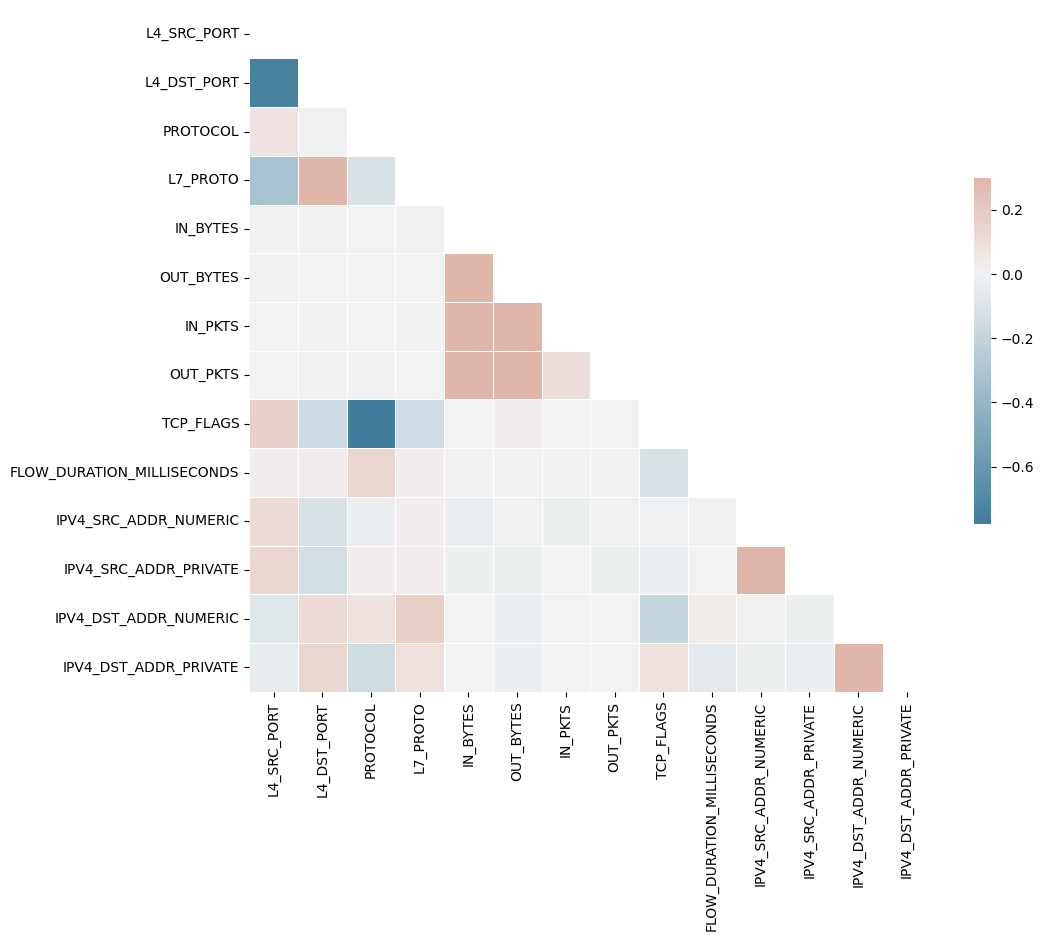

In [18]:
# Calculate the correlation matrix
corr_matrix = features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

plt.show()

## Check for duplicates

In [19]:
duplicates = data[data.duplicated()]

print(f"Number of duplicate rows: {len(duplicates)}")
if not duplicates.empty:
    print("Duplicate rows: ")
    print(duplicates)

Number of duplicate rows: 532323
Duplicate rows: 
         L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  IN_BYTES  OUT_BYTES  \
12             60641           53        17       5.0       108        108   
13             60641           53        17       5.0       108        108   
15             38524           53        17       5.0       100        100   
17             42075           53        17       5.0       108        108   
19             45736           53        17       5.0       100        100   
...              ...          ...       ...       ...       ...        ...   
1379253        60158           53        17       5.0        71         71   
1379254        60158           53        17       5.0        71         71   
1379259        35989           53        17       5.0        67         67   
1379260        52999           53        17       5.0        71         71   
1379261        52999           53        17       5.0        71         71   

         IN_P

In [20]:
data.size

20689110

In [21]:
data = data.drop_duplicates()

In [22]:
data.size

12704265

# Feature selection

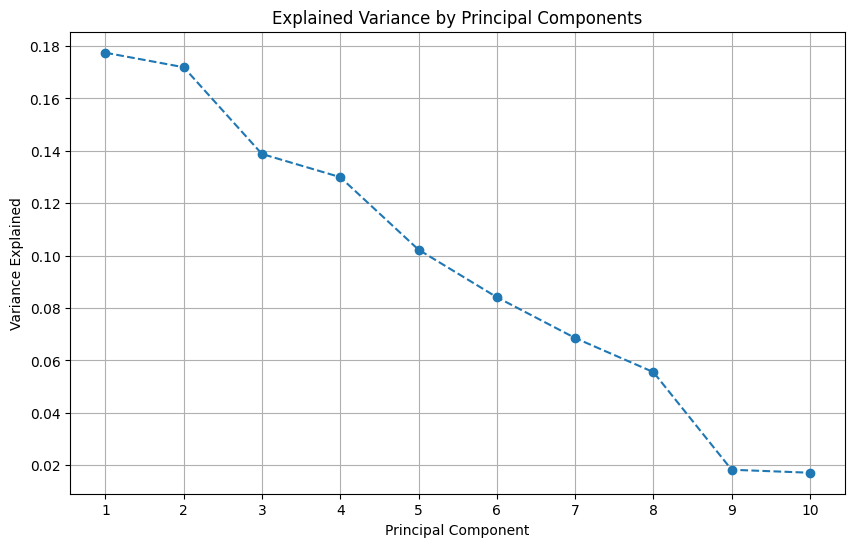

Principal Components and their corresponding features:
   L4_SRC_PORT  L4_DST_PORT  PROTOCOL  L7_PROTO  IN_BYTES  OUT_BYTES  \
0    -0.058446     0.059628  0.002616  0.028037  0.550535   0.519919   
1    -0.446872     0.484054  0.089514  0.288104 -0.059230  -0.080964   
2    -0.066321     0.001420 -0.534940 -0.031117 -0.028870  -0.022247   
3    -0.047456     0.036800 -0.417133  0.232717  0.027988   0.024384   
4     0.473528    -0.405042  0.118096 -0.222670  0.009404  -0.007723   
5     0.001828     0.012764  0.009826 -0.001791 -0.367601   0.389844   
6     0.060894    -0.036940 -0.150258  0.199534 -0.004136  -0.000266   
7     0.265084    -0.279808  0.040925  0.867985 -0.005161   0.002311   
8     0.649936     0.675320  0.109129  0.047831 -0.053586   0.114200   
9    -0.111068    -0.106380  0.003330 -0.005657 -0.372440   0.719245   

    IN_PKTS  OUT_PKTS  TCP_FLAGS  FLOW_DURATION_MILLISECONDS  \
0  0.488108  0.408959  -0.019453                    0.006979   
1 -0.055481 -0.052599  -

In [23]:
# Assuming 'data' is your DataFrame and 'target' is your target variable
# Separate features and target
X = data.drop(columns=["Label"])  # Replace 'Label' with your target column name
y = data["Label"]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Get the explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(explained_variance) + 1),
    explained_variance,
    marker="o",
    linestyle="--",
)
plt.title("Explained Variance by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid()
plt.show()

# Get the components and their corresponding feature names
components = pd.DataFrame(pca.components_, columns=X.columns)

# Display the most important features for each principal component
print("Principal Components and their corresponding features:")
print(components)

# To select the most important features based on the first principal component
important_features = components.iloc[0].abs().nlargest(5)  
print("Top 5 important features based on the first principal component:")
print(important_features)

# Classification

In [24]:
y = np.array(data["Label"])
X = np.array(data[["IN_BYTES", "OUT_BYTES", "IN_PKTS", "OUT_PKTS", "IPV4_SRC_ADDR_NUMERIC"]])

In [25]:
# shuffle the data to make sure that attacks and benign are mixed well
indices = list(range(len(y)))
random.shuffle(indices)
X, y = X[indices], y[indices]
label_counts = np.bincount(y)
print("Labels equal to 1:", label_counts[1])
print("Labels equal to 0:", label_counts[0])

Labels equal to 1: 634140
Labels equal to 0: 212811


In [26]:
splitpoint = int(len(X) * 0.8)
X_train, X_test = X[:splitpoint], X[splitpoint:]
y_train, y_test = y[:splitpoint], y[splitpoint:]

In [27]:
classifier = XGBClassifier(
    booster="gbtree", tree_method="hist", max_depth=3, min_child_weight=1, subsample=0.8
)
classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [28]:
# get the prediction probabilities for all samples (:) and the column that indicates malicious (-1) flows
scores = classifier.predict_proba(X_test)[:,1]

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)

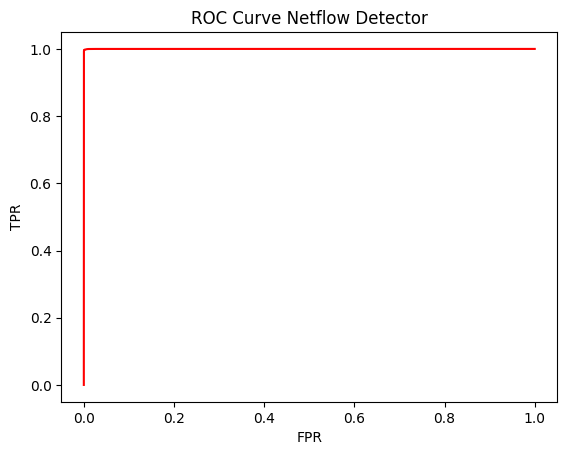

In [30]:
pyplot.plot(fpr, tpr, 'r-')
pyplot.xlabel("FPR")
pyplot.ylabel("TPR")
pyplot.title("ROC Curve Netflow Detector")
pyplot.show()

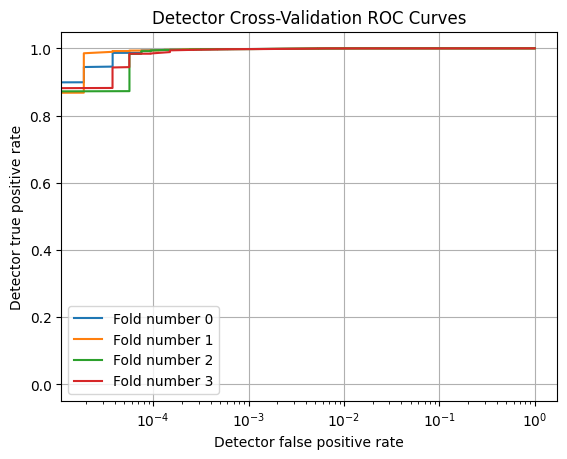

In [31]:
fold_counter = 0

kf = KFold(n_splits=4, shuffle=True)
classifier = RandomForestClassifier(max_depth=20, min_samples_split=20, max_features=4, n_estimators=100, min_samples_leaf=10, bootstrap=True)

for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    classifier.fit(X_train, y_train)
    
    scores = classifier.predict_proba(X_test)[:,-1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
    
    pyplot.semilogx(fpr, tpr, label=f"Fold number {fold_counter}")
    fold_counter += 1
    
pyplot.xlabel("Detector false positive rate")
pyplot.ylabel("Detector true positive rate")
pyplot.title("Detector Cross-Validation ROC Curves")
pyplot.legend()
pyplot.grid()
pyplot.show()

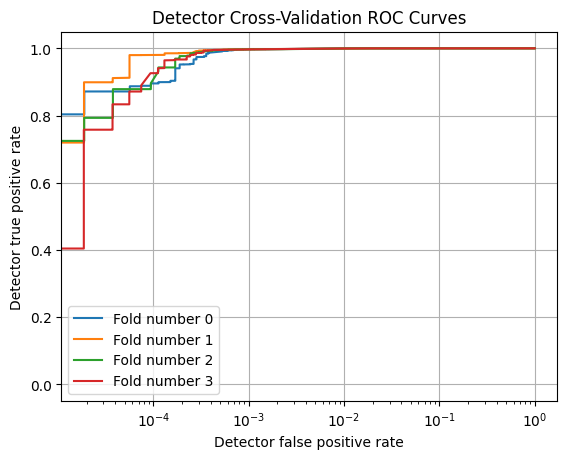

In [32]:
fold_counter = 0

kf = KFold(n_splits=4, shuffle=True)
classifier = XGBClassifier(
    booster="gbtree", tree_method="hist", max_depth=3, min_child_weight=1, subsample=0.8
)

for train, test in kf.split(X):
    X_train, X_test = X[train], X[test]
    y_train, y_test = y[train], y[test]
    
    classifier.fit(X_train, y_train)
    
    scores = classifier.predict_proba(X_test)[:,-1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
    
    pyplot.semilogx(fpr, tpr, label=f"Fold number {fold_counter}")
    fold_counter += 1

pyplot.xlabel("Detector false positive rate")
pyplot.ylabel("Detector true positive rate")
pyplot.title("Detector Cross-Validation ROC Curves")
pyplot.legend()
pyplot.grid()
pyplot.show()

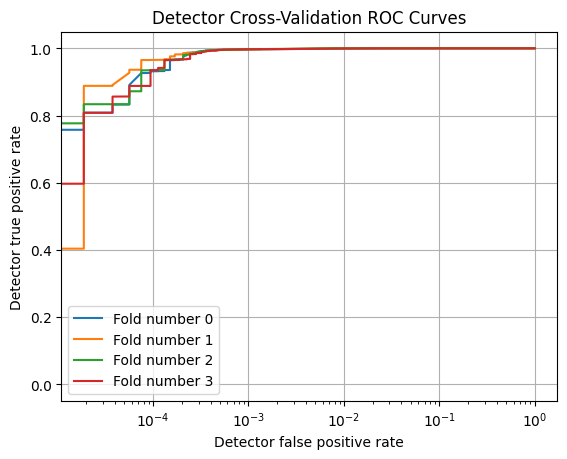

In [33]:
fold_counter = 0

# Initialize stratified k-fold with 4 splits
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Initialize model
model = XGBClassifier(
    booster="gbtree", tree_method="hist", max_depth=3, min_child_weight=1, subsample=0.8
)

# To store results
auc_scores = []

# Loop through each fold
for train_index, test_index in skf.split(X, y):
    # Split into train and test for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Use SMOTE only on the training data to prevent leakage
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Fit the model on resampled data
    model.fit(X_resampled, y_resampled)

    # Predict on the test set
    y_pred = model.predict_proba(X_test)[:, 1]

    scores = classifier.predict_proba(X_test)[:,-1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)

    pyplot.semilogx(fpr, tpr, label=f"Fold number {fold_counter}")
    fold_counter += 1

pyplot.xlabel("Detector false positive rate")
pyplot.ylabel("Detector true positive rate")
pyplot.title("Detector Cross-Validation ROC Curves")
pyplot.legend()
pyplot.grid()
pyplot.show()

In [34]:
#    import seaborn as sns
#    import matplotlib.pyplot as plt

#    # Example: Visualizing a feature in training vs. test set
#    sns.histplot(train_data['feature_name'], color='blue', label='Train', kde=True)
#    sns.histplot(test_data['feature_name'], color='red', label='Test', kde=True)
#    plt.legend()
#    plt.title('Feature Distribution: Train vs. Test')
#    plt.show()